Format lại code

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import math
import torch.multiprocessing as mp
from transformers import BertTokenizerFast
import pickle
# Evaluate
from nltk.translate.bleu_score import sentence_bleu
# from nltk.translate.meteor_score import meteor_score
# from rogue import Rogue
# from pycocoevalcap.cider.cider import Cider
# from pycocoevalcap.spice.spice import Spice
#end
# mp.set_start_method('spawn', force=True)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
detokenize = tokenizer.convert_ids_to_tokens
batch_detokenize = tokenizer.batch_decode
BATCH_SIZE = 64 
#64 : 3.1GB VRAM b16 (3.0 Dedicated | 0.1 Shared)
device = 'cuda'
image_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Dùng cho ImageNet
])


In [ ]:
def load_image(image_folder_path: str): # DataLoader trên Jupyternotebook ko xử lý đa luồng đc nên đành phải load hết vô
    result = {}
    file_counts = len(os.listdir(image_folder_path))
    progress = 0
    last_log = 0
    count = 0
    for file_name in os.listdir(image_folder_path):
        file_path = os.path.join(image_folder_path, file_name)
        if os.path.isfile(file_path):
            id = os.path.splitext(os.path.basename(file_name))[0]
            if id in result: continue
            with Image.open(file_path).convert("RGB") as img:
                image = image_transforms(img)
                result[id] = torch.Tensor(image)
            count += 1
            progress = count / file_counts * 100
            if progress - last_log >= 10:
                last_log = progress
                print(f"Image loading {progress:.2f} % ")
    if last_log != 100:
        print(f"Image loading 100 % ")
    return result
def process_data(image_dict: dict[str, torch.Tensor], processed_data_path: str):
    result: list[tuple[torch.Tensor, torch.Tensor]] = []
    with open(processed_data_path, 'rb') as file:
        processed_data = pickle.load(file)
    for image_id, caption in processed_data:
        caption = torch.tensor(caption)
        image = image_dict[image_id]
        result.append((image, caption))
    return result
def get_train_test_loader(batch_size: int, n_wokers: int = 2):
    image_path = "../Flickr8k/Flicker8k_Dataset"
    train_path = "../Data_bert/train_set_bert.pkl"
    test_path = "../Data_bert/test_set_bert.pkl"
    image_dict: dict[str, torch.Tensor] = load_image(image_path)
    train_data = process_data(image_dict, train_path)
    test_data = process_data(image_dict, test_path)
    trainloader = DataLoader(train_data[:10], batch_size=batch_size, num_workers=n_wokers, shuffle=True)
    testloader = DataLoader(test_data[:10], batch_size=batch_size, num_workers=n_wokers, shuffle=False)
    return trainloader, testloader
trainloader, testloader = get_train_test_loader(BATCH_SIZE, 2)

Image loading 10.01 % 
Image loading 20.02 % 
Image loading 30.03 % 
Image loading 40.04 % 


In [ ]:
# for images, captions in trainloader:
#     for i in range(min(4, captions.shape[0])):
#         print(images[i][:,100,100])
#         print(detokenize(captions[i]))
#     break

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, output_size: int):
        super(EncoderCNN, self).__init__()
        self.inception_model = models.inception_v3(pretrained=True)
        #self.inception_model.fc = torch.nn.Identity()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1000, output_size)
        for name, param in self.inception_model.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
    def forward(self, images: torch.Tensor):
        features = self.inception_model(images) #[1, 2048]
        if isinstance(features, tuple):  # Nếu là tuple
            features = features[0] 
        features = self.relu(features)
        features = self.dropout(features)
        features = self.fc(features)
        return features
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, input_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
    def forward(self, features: torch.Tensor, captions: torch.Tensor, hidden_state: tuple[torch.Tensor, torch.Tensor] = None): 
        # Constant : seq = 1
        # features : [bsz, img_sz]
        # captions : [bsz, seq]
        # hidden : [num_layers, bsz, hidden]
        embeddings = self.embed(captions) # [bsz, seq, embed]
        features = features.unsqueeze(1).expand(-1, embeddings.shape[1], -1) # [bsz, seq, embed]
        combined = torch.cat((features, embeddings), dim=2) # [bsz, seq, img_sz + embed]
        if hidden_state == None:
            hidden_state = (
                torch.zeros(self.num_layers, captions.shape[0], self.hidden_size).to(captions.device),
                torch.zeros(self.num_layers, captions.shape[0], self.hidden_size).to(captions.device)
            )
            # hidden_state : [num_layers, seq, hid] * 2
        # output, hidden_state = self.lstm(combined)
        output, hidden_state = self.lstm(combined, hidden_state)
        # output : [bsz, seq, vocab_size]
        output = self.relu(output)
        output = self.dropout(output)
        output = self.linear(output)
        return output, hidden_state
class ImageToTextModel(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super(ImageToTextModel, self).__init__()
        self.encoder: EncoderCNN = encoder
        self.decoder: DecoderRNN = decoder
    def forward(self, images: torch.Tensor, captions: torch.Tensor):
        # Constant : SEQ_LENGTH = 46, seq = 1
        # images: [bsz, 3, raw_image_width, raw_image_height]
        # captions: [bsz, SEQ_LENGTH]
        bsz = images.shape[0]
        hidden_state: tuple[torch.Tensor, torch.Tensor] = None
        features = self.encoder(images)
        # features: [bsz, img_sz]
        seq_predicted = []
        seq_predicted.append(torch.zeros((bsz, self.decoder.vocab_size), dtype=torch.float32).unsqueeze(1).to(device))
        # seq_predicted : [predict_length, seq, vocab]
        decoder_input = captions[:, 0].unsqueeze(1)
        # decoder_input : [bsz, seq]
        seq_length = captions.shape[1]
        for di in range(1, seq_length):
            output_decoder, hidden_state = self.decoder(features, decoder_input, hidden_state)
            # ouput_decoder: [bsz, seq, vocab]
            # hidden_state: [num_layers, bsz, hidden_size] * 2
            decoder_input = captions[:, di].unsqueeze(1)
            # decoder_input : [bsz, seq]
            seq_predicted.append(output_decoder)
        return torch.cat(seq_predicted, dim=1)
    def predict(self, images: torch.Tensor, captions: torch.Tensor, predict_length: int):
        bsz = images.shape[0]
        hidden_state: tuple[torch.Tensor, torch.Tensor] = None
        features = self.encoder(images)
        seq_predicted = []
        seq_predicted.append(torch.zeros((bsz, self.decoder.vocab_size), dtype=torch.float32).unsqueeze(1).to(device))
        decoder_input = captions
        for _ in range(predict_length-1):
            output_decoder, hidden_state = self.decoder(features, decoder_input, hidden_state)
            seq_predicted.append(output_decoder)
            decoder_input = output_decoder.argmax(2)
        return torch.cat(seq_predicted, dim=1)


In [ ]:
def train(model : ImageToTextModel, dataloader : DataLoader, lossf : callable, optimizer : torch.optim.Optimizer, mixed: bool, device: str):
    model.train()
    epoch_loss = 0
    count = 0
    for images, captions in dataloader:
        optimizer.zero_grad()
        images: torch.Tensor = images.to(device)
        captions: torch.Tensor = captions.to(device)
        if mixed:
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                outputs: torch.Tensor = model(images, captions)
                loss: torch.Tensor = lossf(outputs.view(-1, outputs.shape[2]), captions.view(-1))
        else:
            outputs: torch.Tensor = model(images, captions)
            loss: torch.Tensor = lossf(outputs.view(-1, outputs.shape[2]), captions.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        count += 1 
    return epoch_loss / count
def compute_metrics(predict: torch.Tensor, caption: torch.Tensor): # Quên chưa xóa token đầu ...
    # Accuracy
    is_correct = 1 if predict[1] == caption[1] else 0
    caption: list[str] = detokenize(caption)
    predict: list[str] = detokenize(predict)
    while (caption[-1] == "[PAD]"):
        caption.pop()
    while (predict[-1] == "[PAD]"):
        predict.pop()
    # Bleu
    reference = [caption]
    # print(caption, predict)
    bleu_1 = sentence_bleu(reference, predict, weights=(1, 0, 0, 0))
    bleu_2 = sentence_bleu(reference, predict, weights=(0.5, 0.5, 0, 0))
    bleu_3 = sentence_bleu(reference, predict, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = sentence_bleu(reference, predict)
    # Rogue
    # rogue = Rogue()
    # scores = rogue.get_scores(' '.join(predicts), ' '.join(captions))
    # Meteor
    # meteor_score_ = meteor_score([' '.join(captions)], ' '.join(predicts))
    # Cider, spice
    # cider_scorer = Cider()
    # spice_scorer = Spice()
    # cider_score, _ = cider_scorer.compute_score({0 : [' '.join(caption)]}, {0 : [' '.join(predict)]})
    # spice_score, _ = spice_scorer.compute_score({0 : [' '.join(captions)]}, {0 : [' '.join(predicts)]})
    return {
        "accuracy" : is_correct,
        "bleu_1" : bleu_1,
        "bleu_2" : bleu_2,
        "bleu_3" : bleu_3,
        "bleu_4" : bleu_4,
        # "rogue-1" : scores["rogue-1"]["f"],
        # "rogue-2" : scores["rogue-2"]["f"],
        # "rogue-l" : scores["rogue-l"]["f"],
        # "meteor" : meteor_score_,
        # "cider" : cider_score,
        # "spice" : spice_score
    }
def test(model : ImageToTextModel, dataloader : DataLoader, lossf : callable, mixed: bool, device: str):
    model.eval()
    count = 0
    total_count = 0
    epoch_metrics = {'loss' : 0}
    input = torch.tensor([101]).to(device)
    for images, captions in dataloader:
        images: torch.Tensor = images.to(device)
        captions: torch.Tensor = captions.to(device)
        bsz = images.shape[0]
        inputs = input.unsqueeze(1).expand((bsz, 1))
        if mixed:
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                outputs: torch.Tensor = model.predict(images, inputs, captions.shape[1])
                loss: torch.Tensor= lossf(outputs.view(-1, outputs.shape[2]), captions.view(-1))
        else:
            outputs: torch.Tensor  = model.predict(images, inputs, captions.shape[1])
            loss: torch.Tensor= lossf(outputs.view(-1, outputs.shape[2]), captions.view(-1))
        predicts = outputs.argmax(2)
        count += 1
        total_count += bsz
        epoch_metrics['loss'] += loss.item()
        for i in range(bsz):
            metrics = compute_metrics(predicts[i], captions[i])
            for key in metrics:
                if key not in epoch_metrics:
                    epoch_metrics[key] = metrics[key]
                else:
                    epoch_metrics[key] += metrics[key]
    for key in epoch_metrics:
        if key in ['loss']:
            epoch_metrics[key] /= count
        else:
            epoch_metrics[key] /= total_count
    return epoch_metrics

In [ ]:
import util
image_size = 256
embed_size = 256
hidden_size = 256
encoder = EncoderCNN(
    output_size=image_size
)
decoder = DecoderRNN(
    embed_size=embed_size,
    vocab_size=tokenizer.vocab_size,
    hidden_size=hidden_size,
    input_size=image_size,
    num_layers=1
)
image_to_text_model = ImageToTextModel(
    encoder=encoder,
    decoder=decoder
)
loss_func= nn.CrossEntropyLoss(ignore_index=0)
model_path, train_log = util.train_eval(
    trainloader=trainloader,
    testloader=testloader,
    model=image_to_text_model,
    train_func=train,
    test_func=test,
    lossf=loss_func,
    num_epochs=30,
    lr=4e-3,
    gamma=0.9,
    log_step=1,
    warmup_nepochs=15,
    warmup_lr=1e-3,
    warmup_gamma=1.1,
    save=True,
    mixed_train = True,
    mixed_eval = False,
    save_path="checkpoint/teset_model",
    optimizer_type=torch.optim.Adam,
    device=device,
    metadata_extra={
        "batch_size" : BATCH_SIZE,
        "dataset_name" : "Flickr8k"
    },
    log_metric=True
)

Start train


  3%|▎         | 1/30 [00:06<02:59,  6.20s/it]

Train loss : 10.3236 | Test loss : 10.3108 | Train time : 3.16 s | Lr : 0.00100000
{'loss': 10.310770988464355, 'accuracy': 0.0, 'bleu_1': 0.0, 'bleu_2': 0.0, 'bleu_3': 0.0, 'bleu_4': 0.0}


  7%|▋         | 2/30 [00:12<03:00,  6.43s/it]

Train loss : 10.2457 | Test loss : 10.2954 | Train time : 3.16 s | Lr : 0.00110000
{'loss': 10.295448303222656, 'accuracy': 0.0, 'bleu_1': 0.0, 'bleu_2': 0.0, 'bleu_3': 0.0, 'bleu_4': 0.0}


c:\Users\Anh\.conda\envs\data\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Anh\.conda\envs\data\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Anh\.conda\envs\data\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunc

Train loss : 10.1742 | Test loss : 10.2700 | Train time : 3.05 s | Lr : 0.00121000
{'loss': 10.269963264465332, 'accuracy': 0.7, 'bleu_1': 0.019565217391304346, 'bleu_2': 1.7217409660396425e-155, 'bleu_3': 1.8897744677057445e-204, 'bleu_4': 5.161570919091492e-232}


 13%|█▎        | 4/30 [00:24<02:41,  6.20s/it]

Train loss : 10.0809 | Test loss : 10.2205 | Train time : 3.18 s | Lr : 0.00133100
{'loss': 10.22053050994873, 'accuracy': 0.7, 'bleu_1': 0.08478260869565218, 'bleu_2': 0.045211706876658306, 'bleu_3': 3.832528012368504e-103, 'bleu_4': 3.142985177106943e-155}


 17%|█▋        | 5/30 [00:30<02:33,  6.13s/it]

Train loss : 9.9703 | Test loss : 10.1741 | Train time : 3.08 s | Lr : 0.00146410
{'loss': 10.17410945892334, 'accuracy': 0.7, 'bleu_1': 0.08043478260869566, 'bleu_2': 0.04401272247183679, 'bleu_3': 3.7697246225650283e-103, 'bleu_4': 3.1051102834835303e-155}


 20%|██        | 6/30 [00:36<02:25,  6.08s/it]

Train loss : 9.8371 | Test loss : 10.1123 | Train time : 3.13 s | Lr : 0.00161051
{'loss': 10.112343788146973, 'accuracy': 0.7, 'bleu_1': 0.08043478260869566, 'bleu_2': 0.04401272247183679, 'bleu_3': 3.7697246225650283e-103, 'bleu_4': 3.1051102834835303e-155}


 23%|██▎       | 7/30 [00:42<02:19,  6.06s/it]

Train loss : 9.6564 | Test loss : 10.0224 | Train time : 3.05 s | Lr : 0.00177156
{'loss': 10.02238941192627, 'accuracy': 0.7, 'bleu_1': 0.08043478260869566, 'bleu_2': 0.04401272247183679, 'bleu_3': 3.7697246225650283e-103, 'bleu_4': 3.1051102834835303e-155}


 27%|██▋       | 8/30 [00:49<02:13,  6.05s/it]

Train loss : 9.4343 | Test loss : 9.8941 | Train time : 3.07 s | Lr : 0.00194872
{'loss': 9.894062995910645, 'accuracy': 0.7, 'bleu_1': 0.08043478260869566, 'bleu_2': 0.04401272247183679, 'bleu_3': 3.7697246225650283e-103, 'bleu_4': 3.1051102834835303e-155}


 30%|███       | 9/30 [00:55<02:12,  6.29s/it]

Train loss : 9.1207 | Test loss : 9.4982 | Train time : 3.71 s | Lr : 0.00214359
{'loss': 9.498161315917969, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 33%|███▎      | 10/30 [01:01<02:04,  6.21s/it]

Train loss : 8.6322 | Test loss : 9.0174 | Train time : 3.03 s | Lr : 0.00235795
{'loss': 9.017400741577148, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 37%|███▋      | 11/30 [01:07<01:57,  6.18s/it]

Train loss : 7.9689 | Test loss : 8.5003 | Train time : 3.25 s | Lr : 0.00259374
{'loss': 8.500283241271973, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 40%|████      | 12/30 [01:14<01:55,  6.40s/it]

Train loss : 6.9363 | Test loss : 8.0317 | Train time : 3.42 s | Lr : 0.00285312
{'loss': 8.031746864318848, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 43%|████▎     | 13/30 [01:20<01:46,  6.24s/it]

Train loss : 5.8921 | Test loss : 7.7521 | Train time : 2.95 s | Lr : 0.00313843
{'loss': 7.752081871032715, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 47%|████▋     | 14/30 [01:26<01:38,  6.16s/it]

Train loss : 5.0296 | Test loss : 7.8379 | Train time : 3.04 s | Lr : 0.00345227
{'loss': 7.837880611419678, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 50%|█████     | 15/30 [01:32<01:31,  6.13s/it]

Train loss : 4.5857 | Test loss : 8.1178 | Train time : 2.95 s | Lr : 0.00379750
{'loss': 8.117757797241211, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 53%|█████▎    | 16/30 [01:39<01:26,  6.16s/it]

Train loss : 4.3767 | Test loss : 8.4596 | Train time : 3.23 s | Lr : 0.00400000
{'loss': 8.459571838378906, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 57%|█████▋    | 17/30 [01:46<01:25,  6.56s/it]

Train loss : 4.2282 | Test loss : 8.7261 | Train time : 3.87 s | Lr : 0.00360000
{'loss': 8.72606086730957, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 60%|██████    | 18/30 [01:54<01:23,  6.93s/it]

Train loss : 4.0179 | Test loss : 8.9663 | Train time : 3.87 s | Lr : 0.00324000
{'loss': 8.966318130493164, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 63%|██████▎   | 19/30 [02:01<01:16,  6.98s/it]

Train loss : 3.9303 | Test loss : 9.1688 | Train time : 3.97 s | Lr : 0.00291600
{'loss': 9.168824195861816, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 67%|██████▋   | 20/30 [02:07<01:07,  6.72s/it]

Train loss : 3.8354 | Test loss : 9.3298 | Train time : 3.20 s | Lr : 0.00262440
{'loss': 9.329766273498535, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 70%|███████   | 21/30 [02:13<00:58,  6.45s/it]

Train loss : 3.7928 | Test loss : 9.4814 | Train time : 2.90 s | Lr : 0.00236196
{'loss': 9.481436729431152, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 73%|███████▎  | 22/30 [02:19<00:50,  6.28s/it]

Train loss : 3.7010 | Test loss : 9.5945 | Train time : 3.06 s | Lr : 0.00212576
{'loss': 9.594511032104492, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 77%|███████▋  | 23/30 [02:25<00:43,  6.17s/it]

Train loss : 3.6009 | Test loss : 9.6788 | Train time : 2.99 s | Lr : 0.00191319
{'loss': 9.678814888000488, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 80%|████████  | 24/30 [02:30<00:36,  6.04s/it]

Train loss : 3.4454 | Test loss : 9.7494 | Train time : 2.89 s | Lr : 0.00172187
{'loss': 9.749361038208008, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 83%|████████▎ | 25/30 [02:36<00:30,  6.04s/it]

Train loss : 3.4731 | Test loss : 9.8009 | Train time : 3.03 s | Lr : 0.00154968
{'loss': 9.80092716217041, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 87%|████████▋ | 26/30 [02:42<00:24,  6.03s/it]

Train loss : 3.3719 | Test loss : 9.8409 | Train time : 3.01 s | Lr : 0.00139471
{'loss': 9.840919494628906, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 90%|█████████ | 27/30 [02:48<00:17,  5.96s/it]

Train loss : 3.3878 | Test loss : 9.8714 | Train time : 2.88 s | Lr : 0.00125524
{'loss': 9.871356010437012, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 93%|█████████▎| 28/30 [02:54<00:11,  5.97s/it]

Train loss : 3.2743 | Test loss : 9.8915 | Train time : 3.04 s | Lr : 0.00112972
{'loss': 9.891539573669434, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


 97%|█████████▋| 29/30 [03:00<00:05,  5.93s/it]

Train loss : 3.2728 | Test loss : 9.9068 | Train time : 2.88 s | Lr : 0.00101675
{'loss': 9.906786918640137, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


100%|██████████| 30/30 [03:06<00:00,  6.22s/it]

Train loss : 3.2121 | Test loss : 9.8988 | Train time : 3.02 s | Lr : 0.00091507
{'loss': 9.898792266845703, 'accuracy': 0.7, 'bleu_1': 0.02608695652173913, 'bleu_2': 1.973844012052805e-155, 'bleu_3': 2.0643129098604857e-204, 'bleu_4': 5.5150404173765435e-232}


Complete


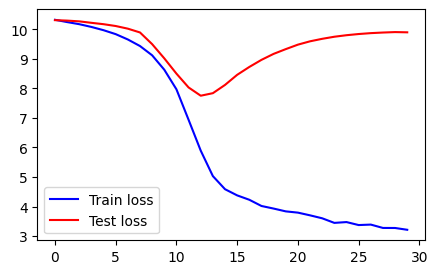

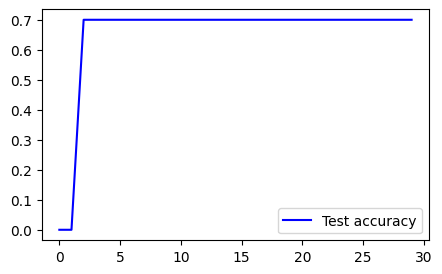

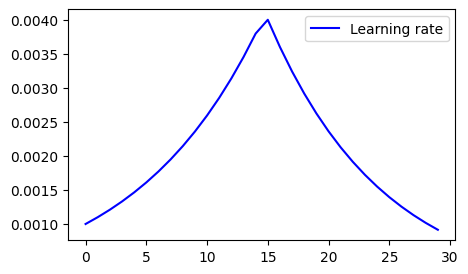

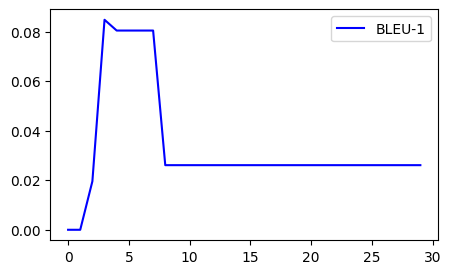

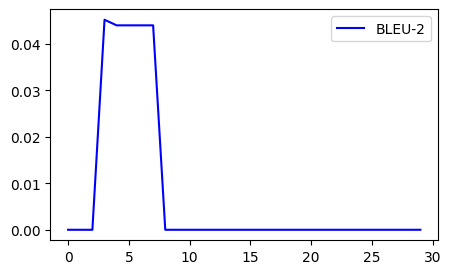

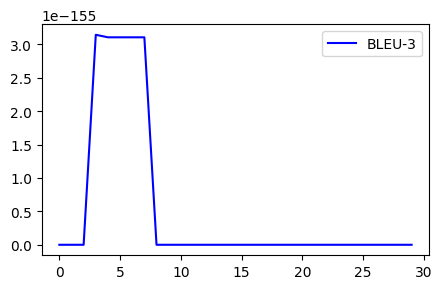

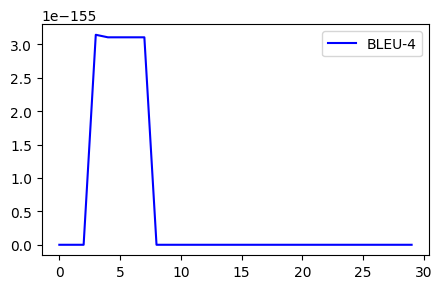

In [ ]:
def plotter(train_log: list[dict[str, object]]) :
    train_loss = []
    test_loss = []
    lr = []
    accuracy = []
    bleu_1 = []
    bleu_2 = []
    bleu_3 = []
    bleu_4 = []
    for train_log_ in train_log:
        train_loss.append(train_log_.get("Train loss", 0))
        test_loss.append(train_log_.get("Test loss", 0))
        lr.append(train_log_.get("Learning rate"))
        metrics: dict[str, object] = train_log_["Metrics"]
        accuracy.append(metrics.get("accuracy"))
        bleu_1.append(metrics.get("bleu_1"))
        bleu_2.append(metrics.get("bleu_2"))
        bleu_3.append(metrics.get("bleu_4"))
        bleu_4.append(metrics.get("bleu_4"))
    plt.figure(figsize=(5,3))
    plt.plot(train_loss, label = "Train loss", color = "blue")
    plt.plot(test_loss, label = "Test loss", color = "red")
    plt.legend()
    plt.figure(figsize=(5,3))
    plt.plot(accuracy, label= "Test accuracy", color = "blue")
    plt.legend()
    plt.figure(figsize=(5,3))
    plt.plot(lr, label= "Learning rate", color = "blue")
    plt.legend()
    plt.figure(figsize=(5,3))
    plt.plot(bleu_1, label= "BLEU-1", color = "blue")
    plt.legend()
    plt.figure(figsize=(5,3))
    plt.plot(bleu_2, label= "BLEU-2", color = "blue")
    plt.legend()
    plt.figure(figsize=(5,3))
    plt.plot(bleu_3, label= "BLEU-3", color = "blue")
    plt.legend()
    plt.figure(figsize=(5,3))
    plt.plot(bleu_4, label= "BLEU-4", color = "blue")
    plt.legend()
plotter(train_log)

In [ ]:
print(image_to_text_model)

ImageToTextModel(
  (encoder): EncoderCNN(
    (inception_model): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.